In [ ]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

## Descarga del conjunto de datos

Para el correcto funcionamiento del código se deberá de descargar previamente el conjunto de datos desde el siguiente enlace https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset  y guardarlo dentro del directorio data/images_all/ y el fichero style.csv en data/

## Filtrado del conjuto de datos

Dado que el dataset es de gran peso (25GB) debido a la limitada capacidad de computo con la que contamos, vamos a seleccionar un subconjunto de imagenes del dataset. Para ello vamos a explorar el dataset.

In [ ]:
# Lectura de metadatos sobre las imagenes

images_info = pd.read_csv('data/styles.csv', on_bad_lines='skip')
print("Numero total de imagenes:", images_info.shape[0])
print("Previsualización:")

images_info.head()

In [ ]:
article_type_counts = images_info['articleType'].value_counts()
article_type_counts.head(10)

In [ ]:
# Seleccionar u subconjunto reducido de imagenes en funcion del tipo y menos de 1000 por cada tipo
selected_types = ['Shirts', 'Tshirts', 'Tops', 'Trousers', 'Shorts', 'Skirts', 'Dresses']

filtered_images = pd.DataFrame()

for article_type in selected_types:
    subset = images_info[images_info['articleType'] == article_type].head(1000)
    filtered_images = pd.concat([filtered_images, subset])

ids_filtered_images = filtered_images['id']
    
print("Numero total de imagenes:", filtered_images.shape[0])
print("Previsualización:")
filtered_images.head()

In [6]:
# Copiar las imagenes seleccionadas al directorio correspondiente
if not os.path.exists('data/images_filtered'):
    os.makedirs('data/images_filtered')

for id in ids_filtered_images:
    file_name = str(id) + '.jpg'  # Asume que la extensión es .jpg
    source_dir = os.path.join('data/images_all', file_name)
    dest_dir = os.path.join('data/images_filtered', file_name)

    if os.path.exists(source_dir):
        shutil.copy(source_dir, dest_dir)

## Reducción de la calidad e igualar tamaño

In [7]:
# Uniformizar el size: recortando y metiendo padding

if not os.path.exists('data/images'):
    os.makedirs('data/images')

common_size = (512,512)

for id in ids_filtered_images:
    file_name_source = str(id) + '.jpg'  
    file_name_dest = str(id) + '.png'  
    source_dir = os.path.join('data/images_filtered', file_name_source)
    dest_dir = os.path.join('data/images', file_name_dest)
    img = cv2.imread(source_dir)   

    if img is None:
        continue
        
    # Calcular a escala de redimension (por dimension)
    height, width = img.shape[:2]
    max_dimension_value = max(height, width)
    scale = common_size[0]/max_dimension_value
    new_height, new_width = (round(height * scale), round(width * scale)) 
    img_resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Calcular el padding (por dimension, si es redimension)
    top_pad = (common_size[1] - new_height) // 2
    bottom_pad = common_size[1] - new_height - top_pad
    left_pad = (common_size[0] - new_width) // 2
    right_pad = common_size[0] - new_width - left_pad
    img_padded = cv2.copyMakeBorder(img_resized, 
                                    top_pad, bottom_pad, left_pad, right_pad, 
                                    cv2.BORDER_CONSTANT, 
                                    value=[255, 255, 255])

    if os.path.exists(source_dir):
        cv2.imwrite(dest_dir, img_padded)

[ WARN:0@46.780] global loadsave.cpp:248 findDecoder imread_('data/images_filtered/39403.jpg'): can't open/read file: check file path/integrity


## Generación de sketches

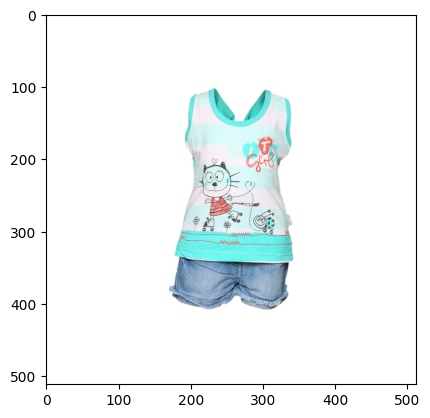

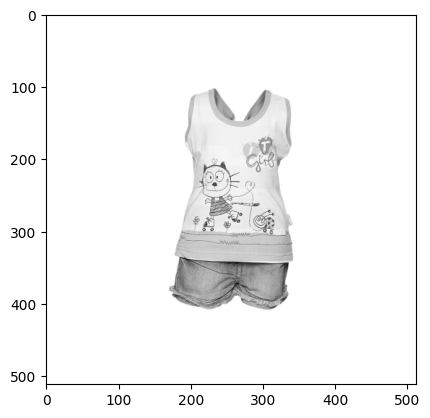

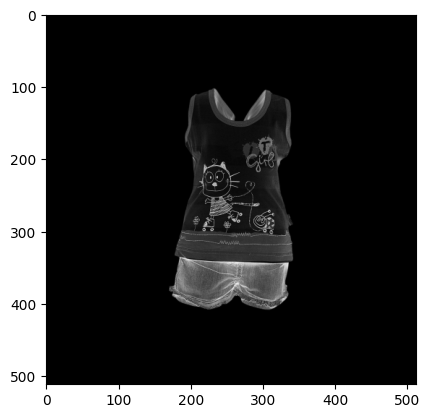

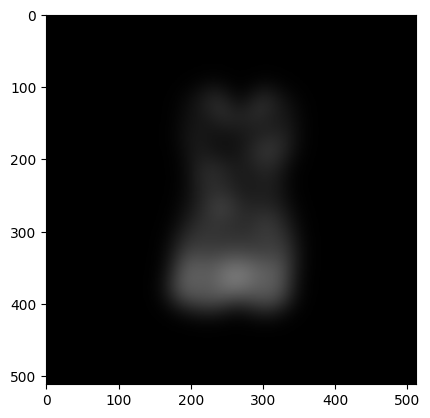

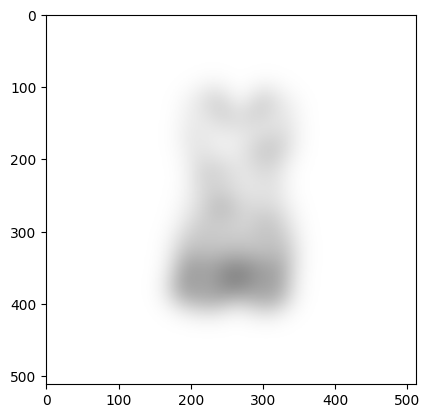

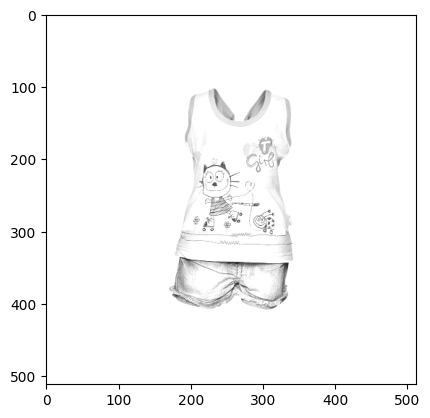

In [8]:
# Prueba de generacion de sketches 

img=cv2.imread("data/images/4927.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

grey_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(grey_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

invert_img=cv2.bitwise_not(grey_img)
img_rgb = cv2.cvtColor(invert_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

blur_img=cv2.GaussianBlur(invert_img, (111,111),0)
img_rgb = cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

invblur_img=cv2.bitwise_not(blur_img)
img_rgb = cv2.cvtColor(invblur_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

sketch_img=cv2.divide(grey_img,invblur_img, scale=256.0)
img_rgb = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [9]:
# Generacion de sketches a partir de todas las imagenes y almacenamiento
source_dir = 'data/images'
dest_dir = 'data/sketches'

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

for filename in os.listdir(source_dir):
    img_path = os.path.join(source_dir, filename)
    img = cv2.imread(img_path)

    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    invert_img = cv2.bitwise_not(grey_img)
    blur_img = cv2.GaussianBlur(invert_img, (111,111), 0)
    invblur_img = cv2.bitwise_not(blur_img)
    sketch_img = cv2.divide(grey_img, invblur_img, scale=256.0)
    sketch_img_rgb = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2RGB)

    save_path = os.path.join(dest_dir, filename)
    cv2.imwrite(save_path, sketch_img_rgb)

## División train/test

In [10]:
id_and_type_filtered_images = filtered_images[['id', 'articleType']]
train, test = train_test_split(id_and_type_filtered_images, test_size=0.2, random_state=42, stratify=id_and_type_filtered_images['articleType'])
train_ids = train['id'].tolist()
test_ids = test['id'].tolist()

In [11]:
if not os.path.exists('data/images/train'):
    os.makedirs('data/images/train')

if not os.path.exists('data/images/test'):
    os.makedirs('data/images/test')

if not os.path.exists('data/sketches/train'):
    os.makedirs('data/sketches/train')
    
if not os.path.exists('data/sketches/test'):
    os.makedirs('data/sketches/test')

In [12]:
for id in train_ids:
    file_name = str(id) + '.png'  # Asume que la extensión es .jpg
    source_dir_image = os.path.join('data/images', file_name)
    dest_dir_image = os.path.join('data/images/train', file_name)
    if os.path.exists(source_dir_image):
        shutil.move(source_dir_image, dest_dir_image)

    source_dir_sketches = os.path.join('data/sketches', file_name)
    dest_dir_sketches = os.path.join('data/sketches/train', file_name)
    if os.path.exists(source_dir_sketches):
        shutil.move(source_dir_sketches, dest_dir_sketches)

In [13]:
for id in test_ids:  # Assuming you have a list of IDs for test data named 'test_ids'
    file_name = str(id) + '.png' 

    # For images
    source_dir_image = os.path.join('data/images', file_name)
    dest_dir_image = os.path.join('data/images/test', file_name)  # Changed to 'test' directory
    if os.path.exists(source_dir_image):
        shutil.move(source_dir_image, dest_dir_image)

    # For sketches
    source_dir_sketches = os.path.join('data/sketches', file_name)
    dest_dir_sketches = os.path.join('data/sketches/test', file_name)  # Changed to 'test' directory
    if os.path.exists(source_dir_sketches):
        shutil.move(source_dir_sketches, dest_dir_sketches)

## Sketches generados con PhotoSketch

Para la generación de bocetos de menos calidad, se hizo uso de la librería PhotoSketch (https://github.com/mtli/PhotoSketch). Si se desean consultar dichos sketches se puede acceder a la siguente carpeta de drive https://uses0-my.sharepoint.com/:f:/g/personal/marlinbar_alum_us_es/Eo56eNZ_XbVDkNXiG9Wfzj0B1PI-gS8D7dJdvsmv_iy0ZQ?e=kJPvqT